In [1]:
%matplotlib inline
%load_ext autoreload

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('../../mbspbs10pc')

from mbspbs10pc import utils

# Check MBS-PBS 10% data availability

In [3]:
ROOT = os.path.join('..','..','..','data')

mbs_files = filter(lambda x: x.startswith('MBS'), os.listdir(ROOT))
pbs_files = filter(lambda x: x.startswith('PBS'), os.listdir(ROOT))
sample_pin_lookout = filter(lambda x: x.startswith('SAMPLE'), os.listdir(ROOT))[0]

print('MBS files:')
for mbs in mbs_files:
    print('{}'.format(os.path.join(ROOT, mbs)))
    
print('PBS files:')
for pbs in pbs_files:
    print('{}'.format(os.path.join(ROOT, pbs)))
    
print('Sample PIN lookout: {}'.format(os.path.join(ROOT, sample_pin_lookout)))

MBS files:
../../../data/MBS_SAMPLE_10PCT_2013.csv
../../../data/MBS_SAMPLE_10PCT_2012.csv
../../../data/MBS_SAMPLE_10PCT_2010.csv
../../../data/MBS_SAMPLE_10PCT_2011.csv
../../../data/MBS_SAMPLE_10PCT_2014.csv
../../../data/MBS_SAMPLE_10PCT_2008.csv
../../../data/MBS_SAMPLE_10PCT_2009.csv
PBS files:
../../../data/PBS_SAMPLE_10PCT_2012.csv
../../../data/PBS_SAMPLE_10PCT_2013.csv
../../../data/PBS_SAMPLE_10PCT_2011.csv
../../../data/PBS_SAMPLE_10PCT_2010.csv
../../../data/PBS_SAMPLE_10PCT_2009.csv
../../../data/PBS_SAMPLE_10PCT_2008.csv
Sample PIN lookout: ../../../data/SAMPLE_PIN_LOOKUP.csv


# PBS take a look

In [4]:
filename = pbs_files[0]
df = pd.read_csv(os.path.join(ROOT, '{}'.format(filename)), header=0, index_col=0, nrows=1000)
df.shape

(1000, 13)

In [5]:
df.head()

,SPPLY_DT,ITM_CD,PBS_RGLTN24_ADJST_QTY,BNFT_AMT,PTNT_CNTRBTN_AMT,SRT_RPT_IND,RGLTN24_IND,DRG_TYP_CD,MJR_SPCLTY_GRP_CD,UNDR_CPRSCRPTN_TYP_CD,PRSCRPTN_CNT,PTNT_CTGRY_DRVD_CD,PTNT_STATE
PTNT_ID,,,,,,,,,,,,,
4599420094,11DEC2012,02236Q,30,0.00,16.01,R,N,GE,1.0,U,1,G2,VIC
5850597601,26NOV2012,08386J,56,72.91,0.00,R,N,GE,1.0,NaN,1,C0,NSW
1237668038,25FEB2012,08214H,30,22.60,35.40,R,N,GE,1.0,NaN,1,G2,VIC
4493310342,18JAN2012,02055E,120,18.92,5.80,R,N,GE,1.0,NaN,1,C1,VIC
2902208774,26DEC2012,02751T,30,11.56,0.00,NaN,N,GE,1.0,NaN,1,C0,SA


# Drugs used in diabetes

In [52]:
_dd = pd.read_csv(os.path.join('..', 'data', 'drugs_used_in_diabetes.csv'), header=0)

# Fix 6-digit notation
dd = set()
for item in _dd.values.ravel():
    if len(item)<6:
        dd.add(str(0)+item)
    else:
        dd.add(item)

# FIXME - exclude Metformins and Sulfonamides
dd = pd.DataFrame(data=list(dd), columns=_dd.columns)
ms = pd.read_csv(os.path.join('..', 'data', 'metformins_sulfonamides.csv'), header=0)
mask = []
for d in dd.values:
    mask.append(d not in ms.values)
dd = pd.DataFrame(data=dd.values[mask], columns=dd.columns)
print(dd.shape)

(76, 1)


In [53]:
dd.head()

,ITM_CD
0,09061X
1,09180E
2,10649L
3,01763T
4,09449H


In [60]:
dd_set = set(list(dd.values.ravel()))

# Filter diabetes

In [7]:
filename = 'PBS_SAMPLE_10PCT_2012.csv'
costs = pd.read_csv(os.path.join(ROOT, '{}'.format(filename)), header=0,
                    usecols=['BNFT_AMT', 'PTNT_CNTRBTN_AMT', 'ITM_CD', 'SPPLY_DT'])
costs.head()

,SPPLY_DT,ITM_CD,BNFT_AMT,PTNT_CNTRBTN_AMT
0,11DEC2012,02236Q,0.00,16.01
1,26NOV2012,08386J,72.91,0.00
2,25FEB2012,08214H,22.60,35.40
3,18JAN2012,02055E,18.92,5.80
4,26DEC2012,02751T,11.56,0.00


In [64]:
dd_costs = costs.loc[costs['ITM_CD'].isin(dd_set)]
print(dd_costs.shape)

(252788, 4)


In [73]:
dd_costs.head(100)

,SPPLY_DT,ITM_CD,BNFT_AMT,PTNT_CNTRBTN_AMT
144,22FEB2012,01763T,188.92,35.4
163,15JUN2012,05476F,567.90,0.0
521,01JAN2012,03423E,170.59,5.8
557,30APR2012,09451K,90.83,5.8
568,18JAN2012,08695P,42.22,35.4
843,03NOV2012,08696Q,93.31,5.8
1015,03MAY2012,08435Y,264.22,0.0
1177,15JAN2012,09449H,59.24,35.4
1300,17JUN2012,09182G,55.79,35.4
1353,17JUL2012,08696Q,93.31,5.8


# Costs plot

In [39]:
#idx = np.where(np.logical_and(costs['PTNT_CNTRBTN_AMT'].values > 0, costs['PTNT_CNTRBTN_AMT'].values < 50))

In [71]:
xx = dd_costs['BNFT_AMT']

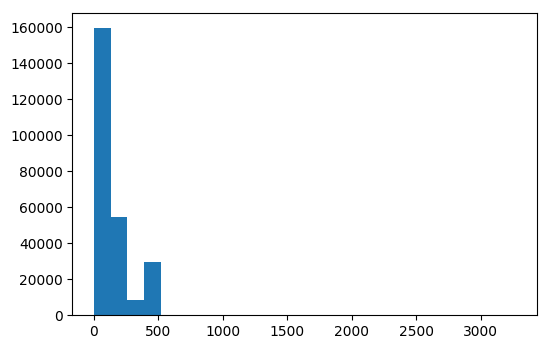

In [72]:
plt.figure(dpi=100)
plt.hist(xx, bins=25);

# Summary plots

In [ ]:
import cPickle as pkl

with open('../tmp/df2.pkl','rb') as f:
    dfy = pkl.load(f)

In [ ]:
plt.figure(dpi=100)
lengths = [len(dfy['PBS_SAMPLE_10PCT_'+str(k)+'.csv']) for k in np.arange(2008,2014)]
plt.plot(np.arange(2008,2014), lengths, '-o')
plt.ylabel('#people using drugs for diabetes')
plt.ylim([0, 50000])
plt.savefig('../tmp/people_using_dd.png');

In [ ]:
starting = []
for target_year in np.arange(2009, 2014):
    # From the target year, go backward and find the subjects
    # that were prescribed with diabete control drugs for the
    # first time
    positive_subjects = set(dfy['PBS_SAMPLE_10PCT_'+str(target_year)+'.csv'])

    for year in np.arange(2008, target_year)[::-1]:
        curr = set(dfy['PBS_SAMPLE_10PCT_'+str(year)+'.csv'])
        positive_subjects = set(filter(lambda x: x not in curr, positive_subjects))
    starting.append(len(positive_subjects))

In [ ]:
plt.figure(dpi=100)
plt.bar(np.arange(len(starting)), starting)
plt.xticks(np.arange(len(starting)), np.arange(2009, 2014))
plt.ylabel('#people started using drugs for diabetes')
plt.title('Max value is: {} achieved in {}'.format(np.max(starting),
                                             np.arange(2009, 2014)[np.argmax(starting)]))
plt.savefig('../tmp/people_started_using_dd.png');